In [1]:
import csv
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

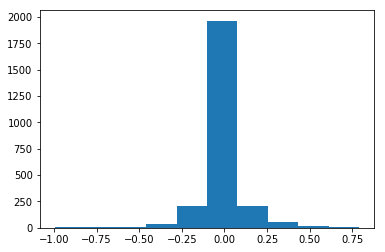

In [2]:
lines = []
steer = []
with open('./driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        lines.append(line)
        steer.append(float(line[3]))
plt.hist(steer)
plt.show()


In [3]:
print(lines[np.random.randint(len(lines))])

['D:\\Google Drive\\Self_driving car\\car_term1\\CNN\\CarND-Behavioral-Cloning-P3\\IMG\\center_2017_08_08_11_15_46_806.jpg', 'D:\\Google Drive\\Self_driving car\\car_term1\\CNN\\CarND-Behavioral-Cloning-P3\\IMG\\left_2017_08_08_11_15_46_806.jpg', 'D:\\Google Drive\\Self_driving car\\car_term1\\CNN\\CarND-Behavioral-Cloning-P3\\IMG\\right_2017_08_08_11_15_46_806.jpg', '0', '1', '0', '30.1903']


In [4]:
# Define Augmentation functinos

# change the size of the image
def change_size_and_normalize(image, new_row, new_col):
	image = cv2.resize(image, (new_col, new_row), interpolation=cv2.INTER_AREA)
	#new_image = image/122.5 - 1
	return image

In [5]:
def cropping(image, top_perc=0.40, bot_perc=0.12):
    top = int(np.ceil(image.shape[0]*top_perc))
    bottom = int(image.shape[0] - np.ceil(image.shape[0]*bot_perc))
    new_image = image[top:bottom,:]
    return new_image
    

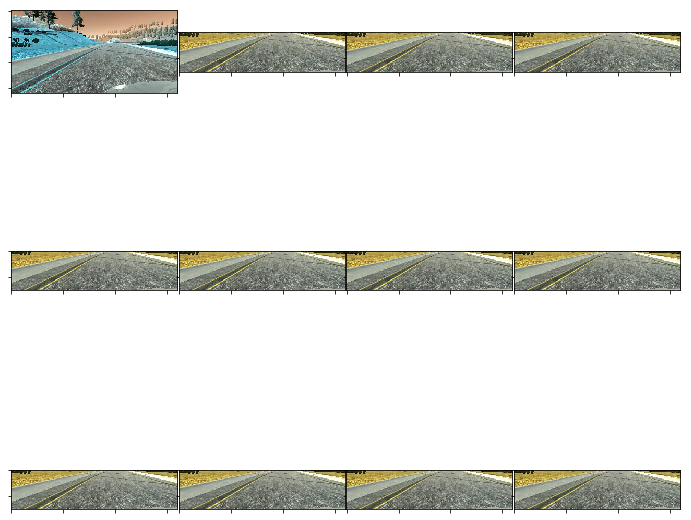

[0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]


In [6]:

# this is a funtion that is used to plot a bunch images after single preprocess
def display_img(lines, img_num):
    img_arr = []
    ang_arr = []
    line = lines[np.random.randint(len(lines))]
    camera_pos = np.random.randint(3)    
    angle = float(line[3])
    ang_arr.append(angle)    
    path = './IMG/' + line[camera_pos].split('\\')[-1]
    image = cv2.imread(path)
    img_arr.append(image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    for i in range(img_num):
        # run preprocess function here and append new image and new angle to arrays
        img_processed = cropping(image)
        ang_processed = angle
        ang_arr.append(ang_processed)
        img_arr.append(img_processed)
    # plot those image both original and processed
    cols = 4
    rows = int(img_num/3+1)
    gs1 = gridspec.GridSpec(rows,cols)
    # fig, axs = plt.subplots(rows, cols)
    gs1.update(wspace=0.01,hspace=0.02)
    plt.figure(figsize=(12,12))
    for i in range(rows):
        for j in range(cols):
            axs1 = plt.subplot(gs1[i,j])
            axs1.set_xticklabels([])
            axs1.set_yticklabels([])
            axs1.set_aspect('equal')
            plt.imshow(img_arr[i+j])
    
    plt.show()
    print(ang_arr)
display_img(lines,6)

In [7]:
# flipping
def flipping(image, angle, flip_prob=0.5):
    p = np.random.uniform()
    if p > 0.5:
        new_image = cv2.flip(image, 1)
        new_angle = angle*(-1.0)
        return new_image, new_angle
    else:
        return image, angle

In [8]:
# changing brightness
def brightness_change(image):
	temp = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
	temp = np.array(temp, dtype = np.float64)
	brigh_rand = .25+ np.random.uniform()
	temp[:,:,2] = temp[:,:,2] * brigh_rand
	temp[:,:,2][temp[:,:,2]>255] = 255
	temp = np.array(temp, dtype=np.uint8)
	new_image = cv2.cvtColor(temp, cv2.COLOR_HSV2RGB)

	return new_image 

In [9]:
# translation of image along x and y axis
def translation(image, angle, trans_range=100):
    rows, cols, ch = image.shape
    tr_x = trans_range * np.random.uniform() - trans_range/2
    tr_y = 40 * np.random.uniform() - 40/2
    trans_mat = np.float32([[1,0,tr_x],[0,1,tr_y]])
    new_angle = angle + tr_x/trans_range*2*.2
    new_image = cv2.warpAffine(image, trans_mat, (cols, rows))

    return new_image, new_angle

In [10]:
# preprocessing procedure for a single image
def preprocess_img(line, new_row, new_col, correction):
    camera_pos = np.random.randint(3)
    angle = float(line[3])
    path = './IMG/' + line[camera_pos].split('\\')[-1]
    if camera_pos == 1:
        angle = angle + correction
    if camera_pos == 2:
        angle = angle - correction
    image = np.array(cv2.imread(path))

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    image = cropping(image)

    image = brightness_change(image)

    #image, angle = translation(image, angle, 100)
    
    image = change_size_and_normalize(image, new_row, new_col)
    
    image, angle = flipping(image, angle)
    
    return image, angle

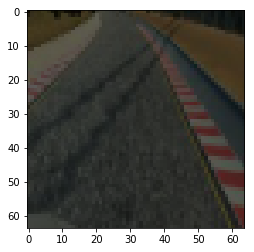

In [11]:
line = lines[np.random.randint(len(lines))]
x, y = preprocess_img(line,64,64,0.002)
plt.imshow(x)
plt.show()

In [12]:
BATCH_SIZE = 1000
bias_threshold = 0.8
new_row=64
new_col=64
batch_img = np.zeros((BATCH_SIZE, new_row, new_col, 3))
batch_ang = np.zeros(BATCH_SIZE)
    # infinite loop for generating data batches
for i in range(BATCH_SIZE):
    keep_pro = 0
    while keep_pro ==0:
        line = lines[np.random.randint(len(lines))]
        temp_img, temp_ang = preprocess_img(line, new_row,new_col,0.229)
        
        if abs(temp_ang) < 0.1:
            rand_prob = np.random.uniform()
                   # print(temp_ang, rand_prob)
            if rand_prob > bias_threshold:
                batch_img[i], batch_ang[i] = temp_img, temp_ang
                keep_pro = 1
        elif abs(temp_ang) < 0.25:
            rand_prob = np.random.uniform()
                   # print(temp_ang, rand_prob)
            if rand_prob > 0.5:
                batch_img[i], batch_ang[i] = temp_img, temp_ang
                keep_pro = 1
        else:
            batch_img[i], batch_ang[i] = temp_img, temp_ang
            keep_pro = 1
    


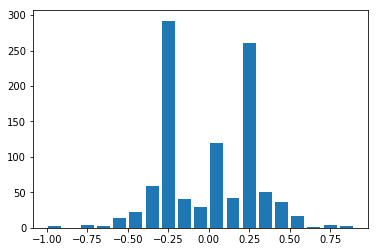

1000


In [13]:
bi =  np.arange(-1,1.0,0.1)
plt.hist(batch_ang, bi,rwidth=0.8)
plt.show()
print(len(batch_ang))

In [14]:
# Generator 
def generator(lines, new_row, new_col, bias_threshold, BATCH_SIZE = 64):
    batch_img = np.zeros((BATCH_SIZE, new_row, new_col, 3))
    batch_ang = np.zeros(BATCH_SIZE)
    # infinite loop for generating data batches
    while 1:
        for i in range(BATCH_SIZE):
            keep_pro = 0
            while keep_pro ==0:
                line = lines[np.random.randint(len(lines))]
                temp_img, temp_ang = preprocess_img(line, new_row,new_col,0.229)
        
                if abs(temp_ang) < 0.1:
                    rand_prob = np.random.uniform()
                   # print(temp_ang, rand_prob)
                    if rand_prob > bias_threshold:
                        batch_img[i], batch_ang[i] = temp_img, temp_ang
                        keep_pro = 1
                elif abs(temp_ang) < 0.25:
                    rand_prob = np.random.uniform()
                   # print(temp_ang, rand_prob)
                    if rand_prob > 0.5:
                        batch_img[i], batch_ang[i] = temp_img, temp_ang
                        keep_pro = 1
                else:
                    batch_img[i], batch_ang[i] = temp_img, temp_ang
                    keep_pro = 1
                    
        yield (batch_img, batch_ang) 
            
                    

generating...


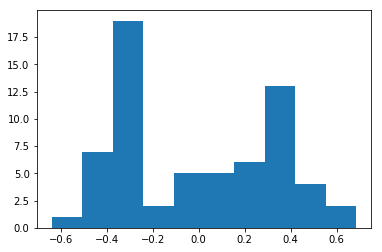

generating...


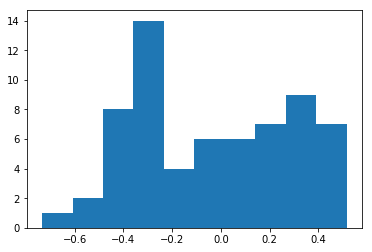

generating...


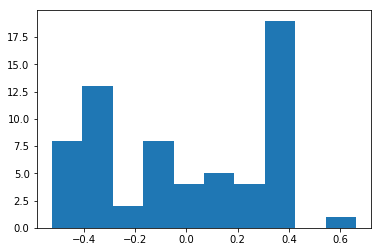

generating...


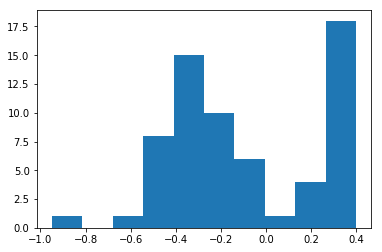

generating...


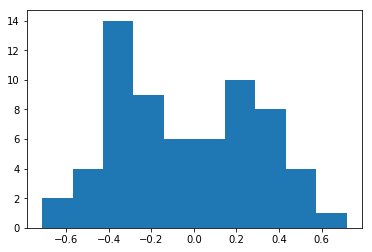

generating...


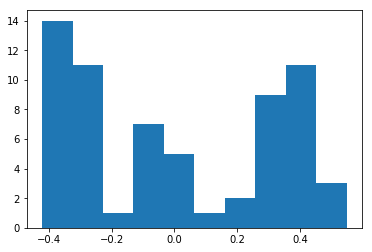

generating...


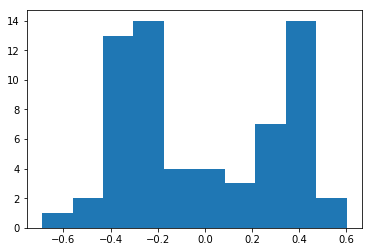

generating...


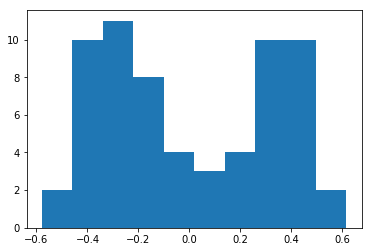

KeyboardInterrupt: 

In [15]:
training = generator(lines,160,320,0.8)
i = 0 
for img, ang in training:
    if i is not 8:
        print('generating...')
        plt.hist(ang)
        plt.show()
        i += 1

In [15]:
# import keras lib
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Dropout, Activation
from keras.layers.convolutional import Convolution2D, Cropping2D
from keras.layers.pooling import MaxPooling2D
from keras.layers import Lambda

model = Sequential()
# cropping the image topPixel from top and botPixel from bottom
#model.add(Cropping2D(cropping=((70, 25), (4, 4)),input_shape=(160,320,3)))
'''# The Following structrue is LeNet 
First conv layer 6 filters with 5*5 kernel
model.add(Convolution2D(6, 5, 5, border_mode='valid', activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.5))

# Second conv layer 6 filters with 5*5 kernel
model.add(Convolution2D(16, 5, 5, border_mode='valid', activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.5))

# three fully connected layers
model.add(Flatten())
model.add(Dense(120, activation='relu'))
model.add(Dense(84, activation='relu'))
model.add(Dense(1))'''

# The Following structure is NVIDIA Model structure
model.add(Lambda(lambda x:(x/122.5) - 1, input_shape=(64,64,3)))
model.add(Convolution2D(24,5,5, subsample=(2,2), border_mode='same', init='he_normal'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))
model.add(Activation('relu'))



model.add(Convolution2D(36,5,5, subsample=(2,2), border_mode='same', init='he_normal'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))
model.add(Activation('relu'))


model.add(Convolution2D(48,5,5, subsample=(2,2), border_mode='same', init='he_normal'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))
model.add(Activation('relu'))

model.add(Convolution2D(64,3,3, subsample=(1,1), border_mode='same', init='he_normal'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))
model.add(Activation('relu'))
model.add(Dropout(0.65))


model.add(Convolution2D(64,3,3, subsample=(1,1), border_mode='same', init='he_normal'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))
model.add(Activation('relu'))
model.add(Dropout(0.65))

model.add(Flatten())
model.add(Dense(1164))
model.add(Activation('relu'))
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dense(50))
model.add(Activation('relu'))
model.add(Dense(10))
model.add(Activation('relu'))
model.add(Dense(1))

Using TensorFlow backend.


In [16]:
# configure learning process 
from keras.optimizers import Adam
learning_rate = 0.0001
model.compile(loss='mse', optimizer=Adam(learning_rate))
# train the model with fixed number of epochs
bias_shreshold = 0.85
single_generator = generator(lines,64,64,bias_shreshold)
model.fit_generator(single_generator, samples_per_epoch=20032, nb_epoch=7)

#history_object = model.fit_generator(train_generator, samples_per_epoch=len(tra))
model.save('model.h5') 
print('model saved.')

Epoch 1/7
20032/20032 [==============================] - 94s - loss: 0.1107    
Epoch 2/7
20032/20032 [==============================] - 93s - loss: 0.0774    
Epoch 3/7
20032/20032 [==============================] - 94s - loss: 0.0773    
Epoch 4/7
20032/20032 [==============================] - 93s - loss: 0.0648    
Epoch 5/7
20032/20032 [==============================] - 93s - loss: 0.0446    
Epoch 6/7
20032/20032 [==============================] - 92s - loss: 0.0356    
Epoch 7/7
20032/20032 [==============================] - 93s - loss: 0.0320    
model saved.
